# Solving a search problem with quantum Walk
 We have a set of rectangular pieces S = { p0, p1, . . . , pn−1 } with the same width and different heights (which are natural numbers): h0, h1, . . . , hn−1. We know that the sum of the heights of the pieces is an even number 2h. We want to know if they can be placed in a box of height h and width twice that of the pieces, placing them vertically.


Given a boolean function f: {0,1, N-1} -> {0,1}, we are looking for x0 so that f(x0)=1 . In this case, f receives a subset of S and outputs 1 if it’s length is h.
We want to find the subset that makes f return 1.

In [ ]:
!pip install qiskit==0.42.1 pylatexenc

In [ ]:
from qiskit import *
from qiskit.tools.monitor import job_monitor

In [ ]:
IBMQ.save_account('', overwrite=True)

### Let's build the complete gate circuit for n=7, h=31 and S = { 1, 3, 4, 5, 13, 17, 19 }
### And obtain the optimal number of steps of the walker, the probability of obtaining the target and the solution

In [ ]:
import math
from qiskit.circuit.library import MCMT
IBMQ.load_account()
# In A_H he value of H is stored, and stays constant
# In A_0 we store the temporary valueof the sum. MOdified y Uf and restored by u_f dagger
n=8 # we need it to be 8 so it is consitent with the coin size 8 = 2^3
two_h=2*31
h_binary_len = round(math.log2(two_h + 1))
coin_size = round(math.log2(n)) # 2^m-1 < n <= 2^m

qc = QuantumCircuit(QuantumRegister(n, 's'), QuantumRegister(1, "f"), QuantumRegister(coin_size, "c"), QuantumRegister(h_binary_len, "a"), QuantumRegister(h_binary_len, "ah"), ClassicalRegister(n), name='main circuit')
f_index = n
coin_index = n+1
ancilla_index = coin_index + coin_size

### Building h in the ancilla qubits in order to represent 31

In [ ]:
qc_h = QuantumCircuit(QuantumRegister(h_binary_len, "ah"), name="Prepare H=31")
# preparing 31
qc_h.x([1,2,3,4,5])

qc.append(qc_h, range(n+4+h_binary_len, n+4+2*h_binary_len))
qc_h.draw()

ah_0: ─────
      ┌───┐
ah_1: ┤ X ├
      ├───┤
ah_2: ┤ X ├
      ├───┤
ah_3: ┤ X ├
      ├───┤
ah_4: ┤ X ├
      ├───┤
ah_5: ┤ X ├
      └───┘

## Initialization of the search space and coin

In [ ]:
qc.h(range(n))
qc.h(range(coin_index, coin_index+3))
qc.barrier()
qc.draw()

┌───┐       ░ 
 s_0: ──────┤ H ├───────░─
            ├───┤       ░ 
 s_1: ──────┤ H ├───────░─
            ├───┤       ░ 
 s_2: ──────┤ H ├───────░─
            ├───┤       ░ 
 s_3: ──────┤ H ├───────░─
            ├───┤       ░ 
 s_4: ──────┤ H ├───────░─
            ├───┤       ░ 
 s_5: ──────┤ H ├───────░─
            ├───┤       ░ 
 s_6: ──────┤ H ├───────░─
            ├───┤       ░ 
 s_7: ──────┤ H ├───────░─
            └───┘       ░ 
   f: ──────────────────░─
            ┌───┐       ░ 
 c_0: ──────┤ H ├───────░─
            ├───┤       ░ 
 c_1: ──────┤ H ├───────░─
            ├───┤       ░ 
 c_2: ──────┤ H ├───────░─
            └───┘       ░ 
 a_0: ──────────────────░─
                        ░ 
 a_1: ──────────────────░─
                        ░ 
 a_2: ──────────────────░─
                        ░ 
 a_3: ──────────────────░─
                        ░ 
 a_4: ──────────────────░─
                        ░ 
 a_5: ──────────────────░─
      ┌───────────────┐ ░ 
ah_0: ┤0              ├─░─
      │               │ ░ 
ah_1: ┤1              ├─░─
      │               │ ░ 
ah_2: ┤2              ├─░─
      │  Prepare H=31 │ ░ 
ah_3: ┤3              ├─░─
      │               │ ░ 
ah_4: ┤4              ├─░─
      │               │ ░ 
ah_5: ┤5              ├─░─
      └───────────────┘ ░ 
c0: 8/════════════════════

In [ ]:
qc_walk_step = QuantumCircuit(QuantumRegister(n, 's'), QuantumRegister(1, "f"), QuantumRegister(coin_size, "c"), QuantumRegister(h_binary_len, "a"), QuantumRegister(h_binary_len, "ah"), name='walk circuit')

### Method for controlled addition on n qubits

In [ ]:
def controled_addition_on_n_qubits(control_index, n=5):
  """
  Adds only if control_index is 1.
  Control index is always the first
  """
  qc = QuantumCircuit(n+1, name="Add one")
  for base_index in range(2, n+1):
    qc.mcx([0] + list(range(base_index, n+1)), base_index-1, mode='noancilla')
  qc.cx(0, n)
  return qc

#Sample
qc_sample = controled_addition_on_n_qubits(5)
qc_sample.draw()

q_0: ──■────■────■────■────■──
     ┌─┴─┐  │    │    │    │  
q_1: ┤ X ├──┼────┼────┼────┼──
     └─┬─┘┌─┴─┐  │    │    │  
q_2: ──■──┤ X ├──┼────┼────┼──
       │  └─┬─┘┌─┴─┐  │    │  
q_3: ──■────■──┤ X ├──┼────┼──
       │    │  └─┬─┘┌─┴─┐  │  
q_4: ──■────■────■──┤ X ├──┼──
       │    │    │  └─┬─┘┌─┴─┐
q_5: ──■────■────■────■──┤ X ├
                         └───┘

## Building Uf, adding the value of each position to the ancilla in case the qubit of said position is ON

In [ ]:
# Uf
circuit_len = n+coin_size+1+2*h_binary_len

S = [1,3,4,5,13,17,19]

qc_uf = QuantumCircuit(QuantumRegister(n, 's'), QuantumRegister(1, "f"), QuantumRegister(coin_size, "c"), QuantumRegister(h_binary_len, "a"), QuantumRegister(h_binary_len, "ah"), name="Uf")

# Add to the ancilla if the qubit is on
# Addition for the qubit 0
for qubit_index, s in enumerate(S):
  qc_aux = QuantumCircuit(QuantumRegister(n, 's'), QuantumRegister(1, "f"), QuantumRegister(coin_size, "c"), QuantumRegister(h_binary_len, "a"), QuantumRegister(h_binary_len, "ah"), name=f"cadd_{s}_if_{qubit_index}")
  for i in range(s):
    qc_aux.append(controled_addition_on_n_qubits(qubit_index, h_binary_len), [qubit_index] + list(range(ancilla_index, ancilla_index+h_binary_len)))
  qc_uf.append(qc_aux, range(circuit_len))

# Sample last qc_aux
qc_aux.draw()

»
 s_0: ────────────────────────────────────────────────────────────────────────»
                                                                              »
 s_1: ────────────────────────────────────────────────────────────────────────»
                                                                              »
 s_2: ────────────────────────────────────────────────────────────────────────»
                                                                              »
 s_3: ────────────────────────────────────────────────────────────────────────»
                                                                              »
 s_4: ────────────────────────────────────────────────────────────────────────»
                                                                              »
 s_5: ────────────────────────────────────────────────────────────────────────»
      ┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐»
 s_6: ┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
      │          ││          ││          ││          ││          ││          │»
 s_7: ┤          ├┤          ├┤          ├┤          ├┤          ├┤          ├»
      │          ││          ││          ││          ││          ││          │»
   f: ┤          ├┤          ├┤          ├┤          ├┤          ├┤          ├»
      │          ││          ││          ││          ││          ││          │»
 c_0: ┤          ├┤          ├┤          ├┤          ├┤          ├┤          ├»
      │          ││          ││          ││          ││          ││          │»
 c_1: ┤          ├┤          ├┤          ├┤          ├┤          ├┤          ├»
      │          ││          ││          ││          ││          ││          │»
 c_2: ┤          ├┤          ├┤          ├┤          ├┤          ├┤          ├»
      │  Add one ││  Add one ││  Add one ││  Add one ││  Add one ││  Add one │»
 a_0: ┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├»
      │          ││          ││          ││          ││          ││          │»
 a_1: ┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├»
      │          ││          ││          ││          ││          ││          │»
 a_2: ┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├»
      │          ││          ││          ││          ││          ││          │»
 a_3: ┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├»
      │          ││          ││          ││          ││          ││          │»
 a_4: ┤5         ├┤5         ├┤5         ├┤5         ├┤5         ├┤5         ├»
      │          ││          ││          ││          ││          ││          │»
 a_5: ┤6         ├┤6         ├┤6         ├┤6         ├┤6         ├┤6         ├»
      └──────────┘└──────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
ah_0: ────────────────────────────────────────────────────────────────────────»
                                                                              »
ah_1: ────────────────────────────────────────────────────────────────────────»
                                                                              »
ah_2: ────────────────────────────────────────────────────────────────────────»
                                                                              »
ah_3: ────────────────────────────────────────────────────────────────────────»
                                                                              »
ah_4: ────────────────────────────────────────────────────────────────────────»
                                                                              »
ah_5: ────────────────────────────────────────────────────────────────────────»
                                                                              »
«                                                                              »
« s_0: ──────────────────────────────────────────────────────────────────────

## Compare Ancilla to H and leave the result in the mark/target qubit

In [ ]:
qc_uf.x([ancilla_index, ancilla_index+h_binary_len])

qc_uf.mcx(list(range(ancilla_index, ancilla_index+h_binary_len)) + list(range(ancilla_index+h_binary_len, ancilla_index+2*h_binary_len)), f_index)

qc_uf.x([ancilla_index, ancilla_index+h_binary_len])

qc_walk_step.append(qc_uf, range(circuit_len))
qc_uf.draw()
# End Uf

┌───────────────┐┌───────────────┐┌───────────────┐┌───────────────┐»
 s_0: ┤0              ├┤0              ├┤0              ├┤0              ├»
      │               ││               ││               ││               │»
 s_1: ┤1              ├┤1              ├┤1              ├┤1              ├»
      │               ││               ││               ││               │»
 s_2: ┤2              ├┤2              ├┤2              ├┤2              ├»
      │               ││               ││               ││               │»
 s_3: ┤3              ├┤3              ├┤3              ├┤3              ├»
      │               ││               ││               ││               │»
 s_4: ┤4              ├┤4              ├┤4              ├┤4              ├»
      │               ││               ││               ││               │»
 s_5: ┤5              ├┤5              ├┤5              ├┤5              ├»
      │               ││               ││               ││               │»
 s_6: ┤6              ├┤6              ├┤6              ├┤6              ├»
      │               ││               ││               ││               │»
 s_7: ┤7              ├┤7              ├┤7              ├┤7              ├»
      │               ││               ││               ││               │»
   f: ┤8              ├┤8              ├┤8              ├┤8              ├»
      │               ││               ││               ││               │»
 c_0: ┤9              ├┤9              ├┤9              ├┤9              ├»
      │               ││               ││               ││               │»
 c_1: ┤10             ├┤10             ├┤10             ├┤10             ├»
      │               ││               ││               ││               │»
 c_2: ┤11             ├┤11             ├┤11             ├┤11             ├»
      │   cadd_1_if_0 ││   cadd_3_if_1 ││   cadd_4_if_2 ││   cadd_5_if_3 │»
 a_0: ┤12             ├┤12             ├┤12             ├┤12             ├»
      │               ││               ││               ││               │»
 a_1: ┤13             ├┤13             ├┤13             ├┤13             ├»
      │               ││               ││               ││               │»
 a_2: ┤14             ├┤14             ├┤14             ├┤14             ├»
      │               ││               ││               ││               │»
 a_3: ┤15             ├┤15             ├┤15             ├┤15             ├»
      │               ││               ││               ││               │»
 a_4: ┤16             ├┤16             ├┤16             ├┤16             ├»
      │               ││               ││               ││               │»
 a_5: ┤17             ├┤17             ├┤17             ├┤17             ├»
      │               ││               ││               ││               │»
ah_0: ┤18             ├┤18             ├┤18             ├┤18             ├»
      │               ││               ││               ││               │»
ah_1: ┤19             ├┤19             ├┤19             ├┤19             ├»
      │               ││               ││               ││               │»
ah_2: ┤20             ├┤20             ├┤20             ├┤20             ├»
      │               ││               ││               ││               │»
ah_3: ┤21             ├┤21             ├┤21             ├┤21             ├»
      │               ││               ││               ││               │»
ah_4: ┤22             ├┤22             ├┤22             ├┤22             ├»
      │               ││               ││               ││               │»
ah_5: ┤23             ├┤23             ├┤23             ├┤23             ├»
      └───────────────┘└───────────────┘└───────────────┘└───────────────┘»
«      ┌────────────────┐┌────────────────┐┌────────────────┐               
« s_0: ┤0               ├┤0               ├┤0               ├───────────────
«      │                ││                ││                │               
« s_1: ┤1               ├┤1               ├┤1      

## Apply -C0 to the Coin in case the target is 1 for 3 qubits

In [ ]:
qc_mark = QuantumCircuit(coin_size+1, name="Mark (-C0)")
coin_index_mark=1
qc_mark.ch(0, coin_index_mark)
qc_mark.ch(0, coin_index_mark+1)
qc_mark.ch(0, coin_index_mark+2)

qc_mark.cx(0, coin_index_mark)
qc_mark.cx(0, coin_index_mark+1)
qc_mark.cx(0, coin_index_mark+2)

# CCCZ
qc_mark.append(MCMT('z', 3, 1), [0, coin_index_mark, coin_index_mark+1, coin_index_mark+2])

qc_mark.cx(0, coin_index_mark)
qc_mark.cx(0, coin_index_mark+1)
qc_mark.cx(0, coin_index_mark+2)

qc_mark.ch(0, coin_index_mark)
qc_mark.ch(0, coin_index_mark+1)
qc_mark.ch(0, coin_index_mark+2)

qc_walk_step.append(qc_mark, range(f_index, f_index+coin_size+1))
qc_mark.draw()

┌───────┐                              
q_0: ──■────■────■────■────■────■──┤0      ├──■────■────■────■────■────■──
     ┌─┴─┐  │    │  ┌─┴─┐  │    │  │       │┌─┴─┐  │    │  ┌─┴─┐  │    │  
q_1: ┤ H ├──┼────┼──┤ X ├──┼────┼──┤1      ├┤ X ├──┼────┼──┤ H ├──┼────┼──
     └───┘┌─┴─┐  │  └───┘┌─┴─┐  │  │  mcmt │└───┘┌─┴─┐  │  └───┘┌─┴─┐  │  
q_2: ─────┤ H ├──┼───────┤ X ├──┼──┤2      ├─────┤ X ├──┼───────┤ H ├──┼──
          └───┘┌─┴─┐     └───┘┌─┴─┐│       │     └───┘┌─┴─┐     └───┘┌─┴─┐
q_3: ──────────┤ H ├──────────┤ X ├┤3      ├──────────┤ X ├──────────┤ H ├
               └───┘          └───┘└───────┘          └───┘          └───┘

## Apply inverse Uf

In [ ]:
qc_walk_step.append(qc_uf.inverse(), range(circuit_len))

## Measure the ancilla and the target to check all qubits are back to 0
#### This is only done while testing

In [ ]:
from qiskit.visualization import plot_histogram
qc_copy = qc.copy()
qc_walk_copy = qc_walk_step.copy()
qc_copy.append(qc_walk_copy, range(circuit_len))
qc_copy.measure(range(ancilla_index-1, ancilla_index+h_binary_len), [0,1,2,3,4,5,6])
qc_copy.draw()

┌───┐       ░ ┌────────────────┐                     
 s_0: ──────┤ H ├───────░─┤0               ├─────────────────────
            ├───┤       ░ │                │                     
 s_1: ──────┤ H ├───────░─┤1               ├─────────────────────
            ├───┤       ░ │                │                     
 s_2: ──────┤ H ├───────░─┤2               ├─────────────────────
            ├───┤       ░ │                │                     
 s_3: ──────┤ H ├───────░─┤3               ├─────────────────────
            ├───┤       ░ │                │                     
 s_4: ──────┤ H ├───────░─┤4               ├─────────────────────
            ├───┤       ░ │                │                     
 s_5: ──────┤ H ├───────░─┤5               ├─────────────────────
            ├───┤       ░ │                │                     
 s_6: ──────┤ H ├───────░─┤6               ├─────────────────────
            ├───┤       ░ │                │                     
 s_7: ──────┤ H ├───────░─┤7               ├─────────────────────
            ├───┤       ░ │                │                     
   f: ──────┤ H ├───────░─┤8               ├─────────────────────
            ├───┤       ░ │                │                     
 c_0: ──────┤ H ├───────░─┤9               ├─────────────────────
            ├───┤       ░ │                │                     
 c_1: ──────┤ H ├───────░─┤10              ├─────────────────────
            └───┘       ░ │                │┌─┐                  
 c_2: ──────────────────░─┤11              ├┤M├──────────────────
                        ░ │   walk circuit │└╥┘┌─┐               
 a_0: ──────────────────░─┤12              ├─╫─┤M├───────────────
                        ░ │                │ ║ └╥┘┌─┐            
 a_1: ──────────────────░─┤13              ├─╫──╫─┤M├────────────
                        ░ │                │ ║  ║ └╥┘┌─┐         
 a_2: ──────────────────░─┤14              ├─╫──╫──╫─┤M├─────────
                        ░ │                │ ║  ║  ║ └╥┘┌─┐      
 a_3: ──────────────────░─┤15              ├─╫──╫──╫──╫─┤M├──────
                        ░ │                │ ║  ║  ║  ║ └╥┘┌─┐   
 a_4: ──────────────────░─┤16              ├─╫──╫──╫──╫──╫─┤M├───
                        ░ │                │ ║  ║  ║  ║  ║ └╥┘┌─┐
 a_5: ──────────────────░─┤17              ├─╫──╫──╫──╫──╫──╫─┤M├
      ┌───────────────┐ ░ │                │ ║  ║  ║  ║  ║  ║ └╥┘
ah_0: ┤0              ├─░─┤18              ├─╫──╫──╫──╫──╫──╫──╫─
      │               │ ░ │                │ ║  ║  ║  ║  ║  ║  ║ 
ah_1: ┤1              ├─░─┤19              ├─╫──╫──╫──╫──╫──╫──╫─
      │               │ ░ │                │ ║  ║  ║  ║  ║  ║  ║ 
ah_2: ┤2              ├─░─┤20              ├─╫──╫──╫──╫──╫──╫──╫─
      │  Prepare H=31 │ ░ │                │ ║  ║  ║  ║  ║  ║  ║ 
ah_3: ┤3              ├─░─┤21              ├─╫──╫──╫──╫──╫──╫──╫─
      │               │ ░ │                │ ║  ║  ║  ║  ║  ║  ║ 
ah_4: ┤4              ├─░─┤22              ├─╫──╫──╫──╫──╫──╫──╫─
      │               │ ░ │                │ ║  ║  ║  ║  ║  ║  ║ 
ah_5: ┤5              ├─░─┤23              ├─╫──╫──╫──╫──╫──╫──╫─
      └───────────────┘ ░ └────────────────┘ ║  ║  ║  ║  ║  ║  ║ 
c5: 8/═══════════════════════════════════════╩══╩══╩══╩══╩══╩══╩═
                                             0  1  2  3  4  5  6

In [ ]:
provider = IBMQ.get_provider(hub = 'ibm-q')
device = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc_copy, backend = device, shots = 1024)

print(job.job_id())

Job Status: job has successfully run


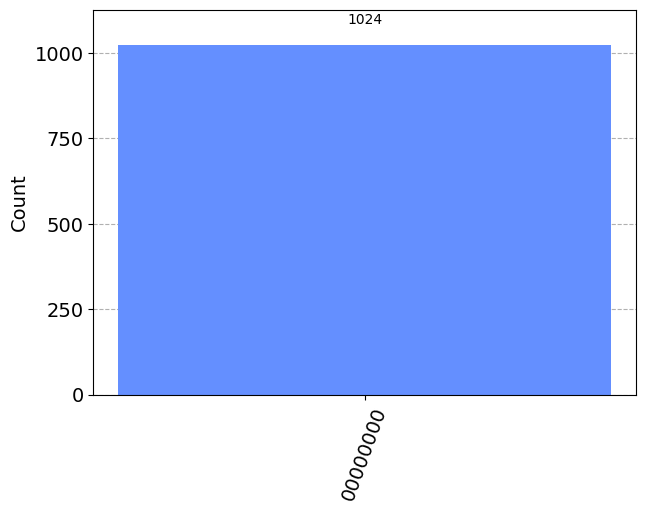

In [ ]:
job_monitor(job)
device_result = job.result()
plot_histogram(device_result.get_counts(qc_copy))

## Applying grover diffusion to the coin. C0 matrix

In [ ]:
qc_diffusion = QuantumCircuit(coin_size, name="Diffusion")
qc_diffusion.h([0,1,2])
qc_diffusion.z(2)
qc_diffusion.x(2)
qc_diffusion.cz(2,1)
qc_diffusion.x(1)
qc_diffusion.ccz(2,1, 0)
qc_diffusion.x([1,2])
qc_diffusion.h([0,1,2])

qc_walk_step.append(qc_diffusion, range(coin_index, coin_index+3))
qc_diffusion.draw()

┌───┐                     ┌───┐     
q_0: ┤ H ├───────────────────■─┤ H ├─────
     ├───┤             ┌───┐ │ ├───┤┌───┐
q_1: ┤ H ├───────────■─┤ X ├─■─┤ X ├┤ H ├
     ├───┤┌───┐┌───┐ │ └───┘ │ ├───┤├───┤
q_2: ┤ H ├┤ Z ├┤ X ├─■───────■─┤ X ├┤ H ├
     └───┘└───┘└───┘           └───┘└───┘

# Walk
## Quantum walk with three qubit coin and 8 qubit walk space

In [ ]:
qc_walk = QuantumCircuit(QuantumRegister(n, 's'), QuantumRegister(1, "f"), QuantumRegister(coin_size, "c"), QuantumRegister(h_binary_len, "a"), QuantumRegister(h_binary_len, "ah"), name="Walk")
qc_walk.mcx(list(range(coin_index, coin_index + coin_size)), 0) #111
qc_walk.x(coin_index + coin_size-1)
qc_walk.mcx(list(range(coin_index, coin_index + coin_size)), 1) #110
qc_walk.x(coin_index + 1)
qc_walk.mcx(list(range(coin_index, coin_index + coin_size)), 3) #100
qc_walk.x(coin_index + coin_size-1)
qc_walk.mcx(list(range(coin_index, coin_index + coin_size)), 2) #101
qc_walk.x(coin_index)
qc_walk.mcx(list(range(coin_index, coin_index + coin_size)), 6) #001
qc_walk.x(coin_index + 1)
qc_walk.mcx(list(range(coin_index, coin_index + coin_size)), 4) #011
qc_walk.x(coin_index + coin_size-1)
qc_walk.mcx(list(range(coin_index, coin_index + coin_size)), 5) #010
qc_walk.x(coin_index + 1)
qc_walk.mcx(list(range(coin_index, coin_index + coin_size)), 7) #000

qc_walk.x(range(coin_index, coin_index + coin_size))
qc_walk.draw()

┌───┐                                                                 »
 s_0: ┤ X ├─────────────────────────────────────────────────────────────────»
      └─┬─┘     ┌───┐                                                       »
 s_1: ──┼───────┤ X ├───────────────────────────────────────────────────────»
        │       └─┬─┘               ┌───┐                                   »
 s_2: ──┼─────────┼─────────────────┤ X ├───────────────────────────────────»
        │         │       ┌───┐     └─┬─┘                                   »
 s_3: ──┼─────────┼───────┤ X ├───────┼─────────────────────────────────────»
        │         │       └─┬─┘       │                 ┌───┐               »
 s_4: ──┼─────────┼─────────┼─────────┼─────────────────┤ X ├───────────────»
        │         │         │         │                 └─┬─┘     ┌───┐     »
 s_5: ──┼─────────┼─────────┼─────────┼───────────────────┼───────┤ X ├─────»
        │         │         │         │       ┌───┐       │       └─┬─┘     »
 s_6: ──┼─────────┼─────────┼─────────┼───────┤ X ├───────┼─────────┼───────»
        │         │         │         │       └─┬─┘       │         │       »
 s_7: ──┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────»
        │         │         │         │         │         │         │       »
   f: ──┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────»
        │         │         │         │  ┌───┐  │         │         │       »
 c_0: ──■─────────■─────────■─────────■──┤ X ├──■─────────■─────────■───────»
        │         │  ┌───┐  │         │  └───┘  │  ┌───┐  │         │  ┌───┐»
 c_1: ──■─────────■──┤ X ├──■─────────■─────────■──┤ X ├──■─────────■──┤ X ├»
        │  ┌───┐  │  └───┘  │  ┌───┐  │         │  └───┘  │  ┌───┐  │  └───┘»
 c_2: ──■──┤ X ├──■─────────■──┤ X ├──■─────────■─────────■──┤ X ├──■───────»
           └───┘               └───┘                         └───┘          »
 a_0: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 a_1: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 a_2: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 a_3: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 a_4: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 a_5: ──────────────────────────────────────────────────────────────────────»
                                                                            »
ah_0: ──────────────────────────────────────────────────────────────────────»
                                                                            »
ah_1: ──────────────────────────────────────────────────────────────────────»
                                                                            »
ah_2: ──────────────────────────────────────────────────────────────────────»
                                                                            »
ah_3: ──────────────────────────────────────────────────────────────────────»
                                                                            »
ah_4: ──────────────────────────────────────────────────────────────────────»
                                                                            »
ah_5: ──────────────────────────────────────────────────────────────────────»
                                                                            »
«                
« s_0: ──────────
«                
« s_1: ──────────
«                
« s_2: ──────────
«                
« s_3: ──────────
«                
« s_4: ──────────
«   

In [ ]:
qc_walk_step.append(qc_walk, range(circuit_len))
qc_walk_step.draw()

┌──────┐               ┌─────────┐              ┌────────┐
 s_0: ┤0     ├───────────────┤0        ├──────────────┤0       ├
      │      │               │         │              │        │
 s_1: ┤1     ├───────────────┤1        ├──────────────┤1       ├
      │      │               │         │              │        │
 s_2: ┤2     ├───────────────┤2        ├──────────────┤2       ├
      │      │               │         │              │        │
 s_3: ┤3     ├───────────────┤3        ├──────────────┤3       ├
      │      │               │         │              │        │
 s_4: ┤4     ├───────────────┤4        ├──────────────┤4       ├
      │      │               │         │              │        │
 s_5: ┤5     ├───────────────┤5        ├──────────────┤5       ├
      │      │               │         │              │        │
 s_6: ┤6     ├───────────────┤6        ├──────────────┤6       ├
      │      │               │         │              │        │
 s_7: ┤7     ├───────────────┤7        ├──────────────┤7       ├
      │      │┌─────────────┐│         │              │        │
   f: ┤8     ├┤0            ├┤8        ├──────────────┤8       ├
      │      ││             ││         │┌────────────┐│        │
 c_0: ┤9     ├┤1            ├┤9        ├┤0           ├┤9       ├
      │      ││  Mark (-C0) ││         ││            ││        │
 c_1: ┤10    ├┤2            ├┤10       ├┤1 Diffusion ├┤10      ├
      │      ││             ││         ││            ││        │
 c_2: ┤11    ├┤3            ├┤11       ├┤2           ├┤11      ├
      │   Uf │└─────────────┘│   Uf_dg │└────────────┘│   Walk │
 a_0: ┤12    ├───────────────┤12       ├──────────────┤12      ├
      │      │               │         │              │        │
 a_1: ┤13    ├───────────────┤13       ├──────────────┤13      ├
      │      │               │         │              │        │
 a_2: ┤14    ├───────────────┤14       ├──────────────┤14      ├
      │      │               │         │              │        │
 a_3: ┤15    ├───────────────┤15       ├──────────────┤15      ├
      │      │               │         │              │        │
 a_4: ┤16    ├───────────────┤16       ├──────────────┤16      ├
      │      │               │         │              │        │
 a_5: ┤17    ├───────────────┤17       ├──────────────┤17      ├
      │      │               │         │              │        │
ah_0: ┤18    ├───────────────┤18       ├──────────────┤18      ├
      │      │               │         │              │        │
ah_1: ┤19    ├───────────────┤19       ├──────────────┤19      ├
      │      │               │         │              │        │
ah_2: ┤20    ├───────────────┤20       ├──────────────┤20      ├
      │      │               │         │              │        │
ah_3: ┤21    ├───────────────┤21       ├──────────────┤21      ├
      │      │               │         │              │        │
ah_4: ┤22    ├───────────────┤22       ├──────────────┤22      ├
      │      │               │         │              │        │
ah_5: ┤23    ├───────────────┤23       ├──────────────┤23      ├
      └──────┘               └─────────┘              └────────┘

### Applying one step of the walk **pi*sqrt(2^n)/2** times

In [ ]:
import math
iterations = int(math.pi*math.sqrt(2**8)/2)
print(f"number of iterations: {iterations}")
for i in range(iterations):
  qc.append(qc_walk_step, range(circuit_len))

number of iterations: 25


In [ ]:
# Measurement
qc.measure(range(n), range(n))
qc.draw()

┌───┐       ░ ┌────────────────┐┌────────────────┐»
 s_0: ──────┤ H ├───────░─┤0               ├┤0               ├»
            ├───┤       ░ │                ││                │»
 s_1: ──────┤ H ├───────░─┤1               ├┤1               ├»
            ├───┤       ░ │                ││                │»
 s_2: ──────┤ H ├───────░─┤2               ├┤2               ├»
            ├───┤       ░ │                ││                │»
 s_3: ──────┤ H ├───────░─┤3               ├┤3               ├»
            ├───┤       ░ │                ││                │»
 s_4: ──────┤ H ├───────░─┤4               ├┤4               ├»
            ├───┤       ░ │                ││                │»
 s_5: ──────┤ H ├───────░─┤5               ├┤5               ├»
            ├───┤       ░ │                ││                │»
 s_6: ──────┤ H ├───────░─┤6               ├┤6               ├»
            ├───┤       ░ │                ││                │»
 s_7: ──────┤ H ├───────░─┤7               ├┤7               ├»
            └───┘       ░ │                ││                │»
   f: ──────────────────░─┤8               ├┤8               ├»
            ┌───┐       ░ │                ││                │»
 c_0: ──────┤ H ├───────░─┤9               ├┤9               ├»
            ├───┤       ░ │                ││                │»
 c_1: ──────┤ H ├───────░─┤10              ├┤10              ├»
            ├───┤       ░ │                ││                │»
 c_2: ──────┤ H ├───────░─┤11              ├┤11              ├»
            └───┘       ░ │   walk circuit ││   walk circuit │»
 a_0: ──────────────────░─┤12              ├┤12              ├»
                        ░ │                ││                │»
 a_1: ──────────────────░─┤13              ├┤13              ├»
                        ░ │                ││                │»
 a_2: ──────────────────░─┤14              ├┤14              ├»
                        ░ │                ││                │»
 a_3: ──────────────────░─┤15              ├┤15              ├»
                        ░ │                ││                │»
 a_4: ──────────────────░─┤16              ├┤16              ├»
                        ░ │                ││                │»
 a_5: ──────────────────░─┤17              ├┤17              ├»
      ┌───────────────┐ ░ │                ││                │»
ah_0: ┤0              ├─░─┤18              ├┤18              ├»
      │               │ ░ │                ││                │»
ah_1: ┤1              ├─░─┤19              ├┤19              ├»
      │               │ ░ │                ││                │»
ah_2: ┤2              ├─░─┤20              ├┤20              ├»
      │  Prepare H=31 │ ░ │                ││                │»
ah_3: ┤3              ├─░─┤21              ├┤21              ├»
      │               │ ░ │                ││                │»
ah_4: ┤4              ├─░─┤22              ├┤22              ├»
      │               │ ░ │                ││                │»
ah_5: ┤5              ├─░─┤23              ├┤23              ├»
      └───────────────┘ ░ └────────────────┘└────────────────┘»
c0: 8/════════════════════════════════════════════════════════»
                                                              »
«      ┌────────────────┐┌────────────────┐┌────────────────┐┌────────────────┐»
« s_0: ┤0               ├┤0               ├┤0               ├┤0               ├»
«      │                ││                ││                ││                │»
« s_1: ┤1               ├┤1               ├┤1               ├┤1               ├»
«      │                ││                ││                ││                │»
« s_2: ┤2               ├┤2               ├┤2               ├┤2               ├»
«      │                ││                ││                ││                │»
« s_3: ┤3               ├┤3               ├┤3               ├┤3               ├»
«      │                ││                ││                ││                │»
« s_4: ┤4          

In [ ]:
print(f"Amount of qubits: {circuit_len}")

Amount of qubits: 24


## Execution on quantum simulator
## The last value must be ignored because we are only using the first seven qubits to represent the set S of the search space

642eceeb962846ac83e97f52
Job Status: job has successfully run


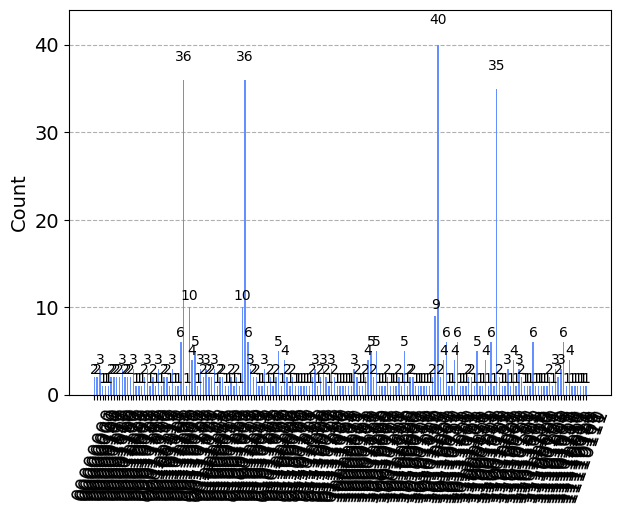

In [ ]:
provider = IBMQ.get_provider(hub = 'ibm-q')
device = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc, backend = device, shots = 512)

print(job.job_id())
job_monitor(job)
device_result = job.result()
plot_histogram(device_result.get_counts(qc))

# Results explained
The results obtained with higher probability are: 00110001, 10110001, 01001110 and 11001110


Removing the first qubit (the last in the circuit as they are printed sideways) because we are using one extra qubit, we have that the two solutions obtained are: 1001110 and 0110001

Using S, it translates to the subsets S0 = {1, 13, 17} and S1 = {3,4,5,19}